# NMF Model Workflow
### This notebook is to represent the entire workflow of a model from:
1. Imports
2. Data Importing
    * Import training data from parquet files
    * Select desired run and lumisections
3. Data Preprocessing
    * Remove cross
    * Normalization?
4. Model Training
    * TODO: Training loss graph?
5. Model Testing
    * Import testing data from parquet files
    * Select desired run and lumisections
    * Remove Cross
    * Predict on testing data
6. Data Postprocessing
    * Add cross back
    * Analyze the binary loss for anomalies
    * Plot testing data, prediction, loss, and binary loss

# 1. <u>Imports

In [1]:
%%time
# imports

import os
import sys
import json
import joblib
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plottools as plottools
importlib.reload(plottools);
from nmf2d import NMF2D

import functions
importlib.reload(functions);
from functions import *
    
#Used to load an extension that can skip the remaining execution of a cell. 
#Used to skip the training so we don't constantly retrain a model
%load_ext skip_kernel_extension
%reload_ext skip_kernel_extension

CPU times: user 1.68 s, sys: 1.44 s, total: 3.11 s
Wall time: 4.48 s


# 2. <ins>Data Importing

### Set path to parquet file

In [2]:
#RING = 1
#RUN, YEAR, ERA, VERSION, PERIOD = 380043, 2024, "C", 1, 1 # 2024 before Disk-1 POG dead
#RUN, YEAR, ERA, VERSION, PERIOD = 382913, 2024, "F", 1, 2 # 2024 after  Disk-1 POG dead (382799) 
#RUN, YEAR, ERA, VERSION, PERIOD = 392642, 2025, "C", 1, 3 # 2025 before multiple ROCs disabled
#RUN, YEAR, ERA, VERSION, PERIOD = 392925, 2025, "C", 1, 4 # 2025 after  multiple ROCs disabled (392668)
#RUN, YEAR, ERA, VERSION, PERIOD = 393240, 2025, "C", 2, 5 # why?

RING = 2
#RUN, YEAR, ERA, VERSION, PERIOD = 380043, 2024, "C", 1, 1 # 2024 before Disk-1 POG dead
#RUN, YEAR, ERA, VERSION, PERIOD = 382913, 2024, "F", 1, 2 # 2024 after  Disk-1 POG dead (382799) 
RUN, YEAR, ERA, VERSION, PERIOD = 392642, 2025, "C", 1, 3 # 2025 before multiple ROCs disabled

file = f'../data/ZeroBias-Run{YEAR}{ERA}-PromptReco-v{VERSION}-DQMIO-PixelPhase1-Phase1_MechanicalView-PXForward-clusters_per_SignedDiskCoord_per_SignedBladePanelCoord_PXRing_{RING}.parquet'
oms_json = f'../omsdata/omsdata_Run{YEAR}{ERA}-v{VERSION}.json'
#ring_num = int(file[-9]) #The -9th character is ALWAYS the ring number for our data

### Import desired run and lumisections

In [3]:
%%time
run_number = RUN
extra_filters = []

if run_number == 380043: # 33 932 (900 Total)
    lumi_start = 33
    lumi_end = 932
elif run_number == 382913: # 41 990 (950 Total) or longer: 41 2327 (2300 Total) except anomalies at LS 1348-50, 2290-91
    lumi_start = 41
    lumi_end = 990
    extra_filters = [('ls_number', '!=', 1348), ('ls_number', '!=', 1349), ('ls_number', '!=', 1350), ('ls_number', '!=', 2290), ('ls_number', '!=', 2291)]
elif run_number == 392642: # 38 984 (900 Total) with many anomalies (i.e. long 483-699) or longer: 38 1932 (1900 Total) ...many anomalies
    lumi_start = 38
    lumi_end = 984
    extra_filters = [('ls_number', '!=', 168), ('ls_number', '!=', 169), ('ls_number', '!=', 170), 
                     ('ls_number', '!=', 210), ('ls_number', '!=', 211), ('ls_number', '!=', 212), ('ls_number', '!=', 213), ('ls_number', '!=', 214), ('ls_number', '!=', 215), ('ls_number', '!=', 216), ('ls_number', '!=', 217), ('ls_number', '!=', 218), ('ls_number', '!=', 219), ('ls_number', '!=', 220), ('ls_number', '!=', 221), ('ls_number', '!=', 222), ('ls_number', '!=', 223), ('ls_number', '!=', 224), ('ls_number', '!=', 225), ('ls_number', '!=', 226), ('ls_number', '!=', 227), ('ls_number', '!=', 228), ('ls_number', '!=', 229), ('ls_number', '!=', 230), ('ls_number', '!=', 231), ('ls_number', '!=', 232), ('ls_number', '!=', 233), ('ls_number', '!=', 234), ('ls_number', '!=', 235), ('ls_number', '!=', 236), ('ls_number', '!=', 237), ('ls_number', '!=', 238), 
                     ('ls_number', '!=', 523), ('ls_number', '!=', 524), ('ls_number', '!=', 525), ('ls_number', '!=', 526),
                     ('ls_number', '!=', 573), ('ls_number', '!=', 574), ('ls_number', '!=', 575), ('ls_number', '!=', 576), ('ls_number', '!=', 577), ('ls_number', '!=', 578),
                     ('ls_number', '!=', 853), ('ls_number', '!=', 854), ('ls_number', '!=', 855), ('ls_number', '!=', 856),
                     ('ls_number', '!=', 1775),('ls_number', '!=', 1776),('ls_number', '!=', 1777), ('ls_number', '!=', 1778), ('ls_number', '!=', 1779)]
elif run_number == 392925: # 39 1160 (900 Total) with many anomalies (i.e. long 483-699) or longer: 39 1921 (1900 Total) 
    lumi_start = 39
    lumi_end = 1160
    extra_filters = [('ls_number', '!=', 697), ('ls_number', '!=', 698), ('ls_number', '!=', 699), 
                     ('ls_number', '!=', 429), ('ls_number', '!=', 430), ('ls_number', '!=', 431), ('ls_number', '!=', 432), ('ls_number', '!=', 433), 
                     ('ls_number', '!=', 483), ('ls_number', '!=', 484), ('ls_number', '!=', 485), ('ls_number', '!=', 486), ('ls_number', '!=', 487), ('ls_number', '!=', 488), ('ls_number', '!=', 489), ('ls_number', '!=', 490), ('ls_number', '!=', 491), ('ls_number', '!=', 492), ('ls_number', '!=', 493), ('ls_number', '!=', 494), ('ls_number', '!=', 495), ('ls_number', '!=', 496), ('ls_number', '!=', 497), ('ls_number', '!=', 498), ('ls_number', '!=', 499), ('ls_number', '!=', 500), ('ls_number', '!=', 501), ('ls_number', '!=', 502), ('ls_number', '!=', 503), ('ls_number', '!=', 504), ('ls_number', '!=', 505), ('ls_number', '!=', 506), ('ls_number', '!=', 507), ('ls_number', '!=', 508), ('ls_number', '!=', 509), ('ls_number', '!=', 510), ('ls_number', '!=', 511), ('ls_number', '!=', 512), ('ls_number', '!=', 513), ('ls_number', '!=', 514), ('ls_number', '!=', 515), ('ls_number', '!=', 516), ('ls_number', '!=', 517), ('ls_number', '!=', 518), ('ls_number', '!=', 519), ('ls_number', '!=', 520), ('ls_number', '!=', 521), ('ls_number', '!=', 522), ('ls_number', '!=', 523), ('ls_number', '!=', 524), ('ls_number', '!=', 525), ('ls_number', '!=', 526), ('ls_number', '!=', 527), ('ls_number', '!=', 528), ('ls_number', '!=', 529), ('ls_number', '!=', 530), ('ls_number', '!=', 531), ('ls_number', '!=', 532), ('ls_number', '!=', 533), ('ls_number', '!=', 534), ('ls_number', '!=', 535), ('ls_number', '!=', 536), ('ls_number', '!=', 537), ('ls_number', '!=', 538), ('ls_number', '!=', 539), ('ls_number', '!=', 540), ('ls_number', '!=', 541), ('ls_number', '!=', 542), ('ls_number', '!=', 543), ('ls_number', '!=', 544), ('ls_number', '!=', 545), ('ls_number', '!=', 546), ('ls_number', '!=', 547), ('ls_number', '!=', 548), ('ls_number', '!=', 549), ('ls_number', '!=', 550), ('ls_number', '!=', 551), ('ls_number', '!=', 552), ('ls_number', '!=', 553), ('ls_number', '!=', 554), ('ls_number', '!=', 555), ('ls_number', '!=', 556), ('ls_number', '!=', 557), ('ls_number', '!=', 558), ('ls_number', '!=', 559), ('ls_number', '!=', 560), ('ls_number', '!=', 561), ('ls_number', '!=', 562), ('ls_number', '!=', 563), ('ls_number', '!=', 564), ('ls_number', '!=', 565), ('ls_number', '!=', 566), ('ls_number', '!=', 567), ('ls_number', '!=', 568), ('ls_number', '!=', 569), ('ls_number', '!=', 570), ('ls_number', '!=', 571), ('ls_number', '!=', 572), ('ls_number', '!=', 573), ('ls_number', '!=', 574), ('ls_number', '!=', 575), ('ls_number', '!=', 576), ('ls_number', '!=', 577), ('ls_number', '!=', 578), ('ls_number', '!=', 579), ('ls_number', '!=', 580), ('ls_number', '!=', 581), ('ls_number', '!=', 582), ('ls_number', '!=', 583), ('ls_number', '!=', 584), ('ls_number', '!=', 585), ('ls_number', '!=', 586), ('ls_number', '!=', 587), ('ls_number', '!=', 588), ('ls_number', '!=', 589), ('ls_number', '!=', 590), ('ls_number', '!=', 591), ('ls_number', '!=', 592), ('ls_number', '!=', 593), ('ls_number', '!=', 594), ('ls_number', '!=', 595), ('ls_number', '!=', 596), ('ls_number', '!=', 597), ('ls_number', '!=', 598), ('ls_number', '!=', 599), ('ls_number', '!=', 600), ('ls_number', '!=', 601), ('ls_number', '!=', 602), ('ls_number', '!=', 603), ('ls_number', '!=', 604), ('ls_number', '!=', 605), ('ls_number', '!=', 606), ('ls_number', '!=', 607), ('ls_number', '!=', 608), ('ls_number', '!=', 609), ('ls_number', '!=', 610), ('ls_number', '!=', 611), ('ls_number', '!=', 612), ('ls_number', '!=', 613), ('ls_number', '!=', 614), ('ls_number', '!=', 615), ('ls_number', '!=', 616), ('ls_number', '!=', 617), ('ls_number', '!=', 618), ('ls_number', '!=', 619), ('ls_number', '!=', 620), ('ls_number', '!=', 621), ('ls_number', '!=', 622), ('ls_number', '!=', 623), ('ls_number', '!=', 624), ('ls_number', '!=', 625), ('ls_number', '!=', 626), ('ls_number', '!=', 627), ('ls_number', '!=', 628), ('ls_number', '!=', 629), ('ls_number', '!=', 630), ('ls_number', '!=', 631), ('ls_number', '!=', 632), ('ls_number', '!=', 633), ('ls_number', '!=', 634), ('ls_number', '!=', 635), ('ls_number', '!=', 636), ('ls_number', '!=', 637), ('ls_number', '!=', 638), ('ls_number', '!=', 639), ('ls_number', '!=', 640), ('ls_number', '!=', 641), ('ls_number', '!=', 642), ('ls_number', '!=', 643), ('ls_number', '!=', 644), ('ls_number', '!=', 645), ('ls_number', '!=', 646), ('ls_number', '!=', 647), ('ls_number', '!=', 648), ('ls_number', '!=', 649), ('ls_number', '!=', 650), ('ls_number', '!=', 651), ('ls_number', '!=', 652), ('ls_number', '!=', 653), ('ls_number', '!=', 654), ('ls_number', '!=', 655), ('ls_number', '!=', 656), ('ls_number', '!=', 657), ('ls_number', '!=', 658), ('ls_number', '!=', 659), ('ls_number', '!=', 660), ('ls_number', '!=', 661), ('ls_number', '!=', 662), ('ls_number', '!=', 663), ('ls_number', '!=', 664), ('ls_number', '!=', 665), ('ls_number', '!=', 666), ('ls_number', '!=', 667), ('ls_number', '!=', 668), ('ls_number', '!=', 669), ('ls_number', '!=', 670), ('ls_number', '!=', 671), ('ls_number', '!=', 672), ('ls_number', '!=', 673), ('ls_number', '!=', 674), ('ls_number', '!=', 675), ('ls_number', '!=', 676), ('ls_number', '!=', 677), ('ls_number', '!=', 678), ('ls_number', '!=', 679), ('ls_number', '!=', 680), ('ls_number', '!=', 681), ('ls_number', '!=', 682), ('ls_number', '!=', 683), ('ls_number', '!=', 684), ('ls_number', '!=', 685), ('ls_number', '!=', 686), ('ls_number', '!=', 687), ('ls_number', '!=', 688), ('ls_number', '!=', 689), ('ls_number', '!=', 690), ('ls_number', '!=', 691), ('ls_number', '!=', 692), ('ls_number', '!=', 693), ('ls_number', '!=', 694), ('ls_number', '!=', 695), ('ls_number', '!=', 696), ('ls_number', '!=', 697), ('ls_number', '!=', 698), ('ls_number', '!=', 699) 
                    ]
elif run_number == 393240: # 39 962 (900 Total) or longer: 39 1921 (1900 Total) except anomalies at LS 3533-35
    lumi_start = 39
    lumi_end = 962
    extra_filters = [('ls_number', '!=', 3533), ('ls_number', '!=', 3534), ('ls_number', '!=', 3535)] 
                   

multi_lumi_data, lumisections = extract_data_2d_all_lumis(file, run_number, oms_json, extra_filters=extra_filters)
print("Multi Lumi Data WITH Cross Shape: ", multi_lumi_data.shape, "\n")
print("Extracted Lumisections: ", lumisections, "\n")

Multi Lumi Data WITH Cross Shape:  (1844, 140, 56) 

Extracted Lumisections:  [  38   39   40 ... 1932 1933 1934] 

CPU times: user 6.7 s, sys: 12.1 s, total: 18.8 s
Wall time: 20.9 s
Compiler : 116 ms


### Ignore (import the Whole Era)

In [4]:
#%%time
#multi_lumi_data, all_runs, lumisections, df = extract_data_whole_era(file, oms_json, extra_filters=[])
#del df
#all_runs, indices = np.unique(all_runs, return_index=True)
#indices = indices[1:] #The first index in indices is always 0, since the first number is always unique, so we discard that. 
#print(f"There are {len(all_runs)} Runs and {len(lumisections)} Lumisections that Pass All DCS Flags: \n", all_runs)

### Ignore (inspect specific LS)

In [5]:
#desired_lumi = 709
#lumi_index = lumiToIndex(lumisections, desired_lumi)
#print("Index of Lumisection {}: ".format(desired_lumi), lumi_index)
#save_digis_png(multi_lumi_data[lumi_index], run_number, desired_lumi, RING)

# 3. <ins>Data Preprocessing
### Remove Cross

In [6]:
%%time
multi_lumi_data_no_cross = remove_cross(multi_lumi_data, RING)
print("Multi Lumi Data WITHOUT Cross Shape: ", multi_lumi_data_no_cross.shape, "\n")

Multi Lumi Data WITHOUT Cross Shape:  (1844, 136, 48) 

CPU times: user 32.7 ms, sys: 22.1 ms, total: 54.9 ms
Wall time: 50.5 ms


# 4. <ins>Model Training

### Train the Model and Plot Components

In [7]:
%%time
%%skip False
#Set True if you'd like to avoid retraining the model. 

nmfResult = None
batch_size = 3000
num_components = 5
nbatches = 30

# make the NMF model for this era
nmf = NMF2D(n_components=num_components, forget_factor=1, batch_size=batch_size, verbose=True,
            tol=0.0, max_no_improvement=100, max_iter=1000,
            alpha_H=0.1)

# training settings
verbose = True
#min_entries = 0.5e6
min_entries = None

# loop over random batches
for batchidx in range(nbatches):

    # load batch
    if verbose and batchidx % 5 == 0: print(f'Now processing batch {batchidx+1} / {nbatches}...')

    # fit NMF
    nmf.fit(multi_lumi_data_no_cross)
    nmfResult = nmf

print("Model Shape: ", nmfResult.xshape)
print('Training COMPLETED')

Now processing batch 1 / 30...
Now processing batch 6 / 30...
Now processing batch 11 / 30...
Now processing batch 16 / 30...
Now processing batch 21 / 30...
Now processing batch 26 / 30...
Model Shape:  [136, 48]
Training COMPLETED
CPU times: user 33.5 s, sys: 43.3 s, total: 1min 16s
Wall time: 19.2 s


### Save the Model / Load the Model

Saved Model at ../models/model_7_PXRing_2_period_3_type_1.pkl


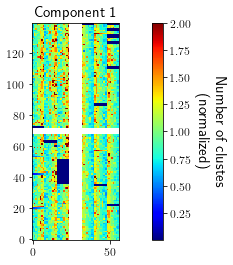

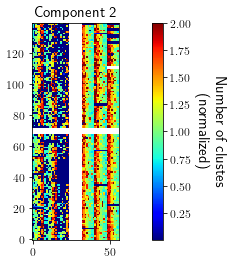

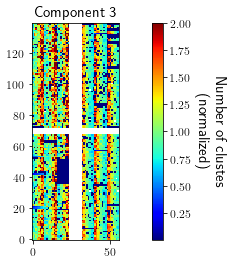

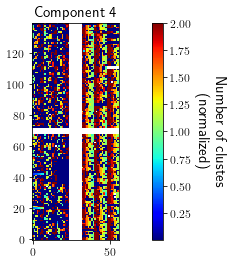

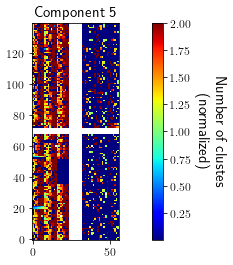

In [8]:
# save the models

dosave = True
do_plot_components = True

number = 7
type = 1

model_name = f'model_{number}_PXRing_{RING}_period_{PERIOD}_type_{type}.pkl'

outputdir = f'../models'
modelfile = os.path.join(outputdir, model_name)

if os.path.exists(modelfile):
    print("Sorry, model already exists...")
    continue

if dosave:# Save the new model
    joblib.dump(nmfResult, modelfile)
    print(f"Saved Model at {modelfile}")
else:# Load an already produced model
    nmf = joblib.load(modelfile)
    print(f"Loaded Model {modelfile}")
    print(f"Model Shape: {nmf.xshape}")
    
# plot components
if do_plot_components:
     C = nmf.components
     C_with_cross = add_cross(C)
     for idx in range(len(C)):
         fig, ax = plottools.plot_hist_2d(C_with_cross[idx],
                title=f'Component {idx+1}', titlesize=15,
                xaxtitle=None, xaxtitlesize=None, yaxtitle=None, yaxtitlesize=None,
                ticklabelsize=12, colorticklabelsize=12, extent=None, aspect=None,
                docolorbar=True, caxtitle='Number of clustes\n(normalized)',
                caxrange=(1e-6, 2),
                caxtitlesize=15, caxtitleoffset=35,
                origin='lower')
         plt.savefig(f'../models/components/model_{number}_component_{idx+1}.png', dpi=300)
     plt.show()
     plt.close()